# `CNModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [2]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [3]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]
Upper state quantum numbers: ['1 0 1 1', '1 0 

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

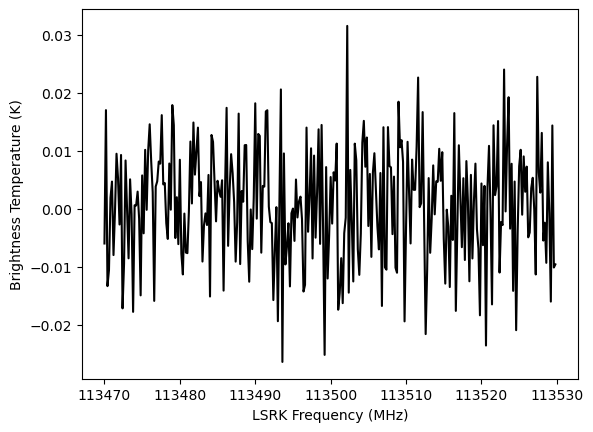

In [4]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# CN model dataset can be named anything, here we name it "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(brightness_data)
observation._brightness_scale = observation.noise
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

Transition 113144.19 is constraining upper state 3 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]]

tau_peak

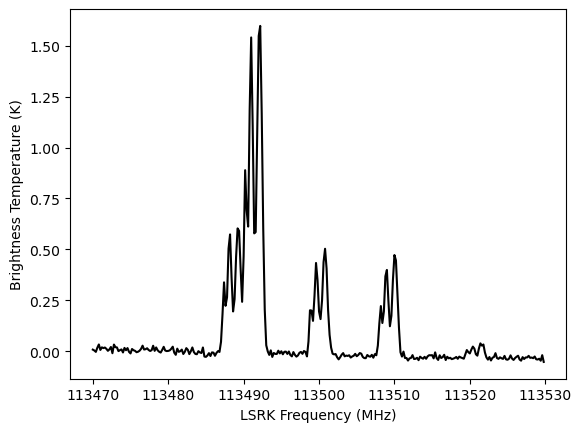

In [5]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [12.5, 12.2, 11.8],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [-2.0, -5.0, 8.0],
}
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")
Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau_peak = model.model.tau_peak.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau_peak:")
print(tau_peak)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(sim_brightness)
observation._brightness_scale = observation.noise
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [51]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 0.5], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 0.5, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 3 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


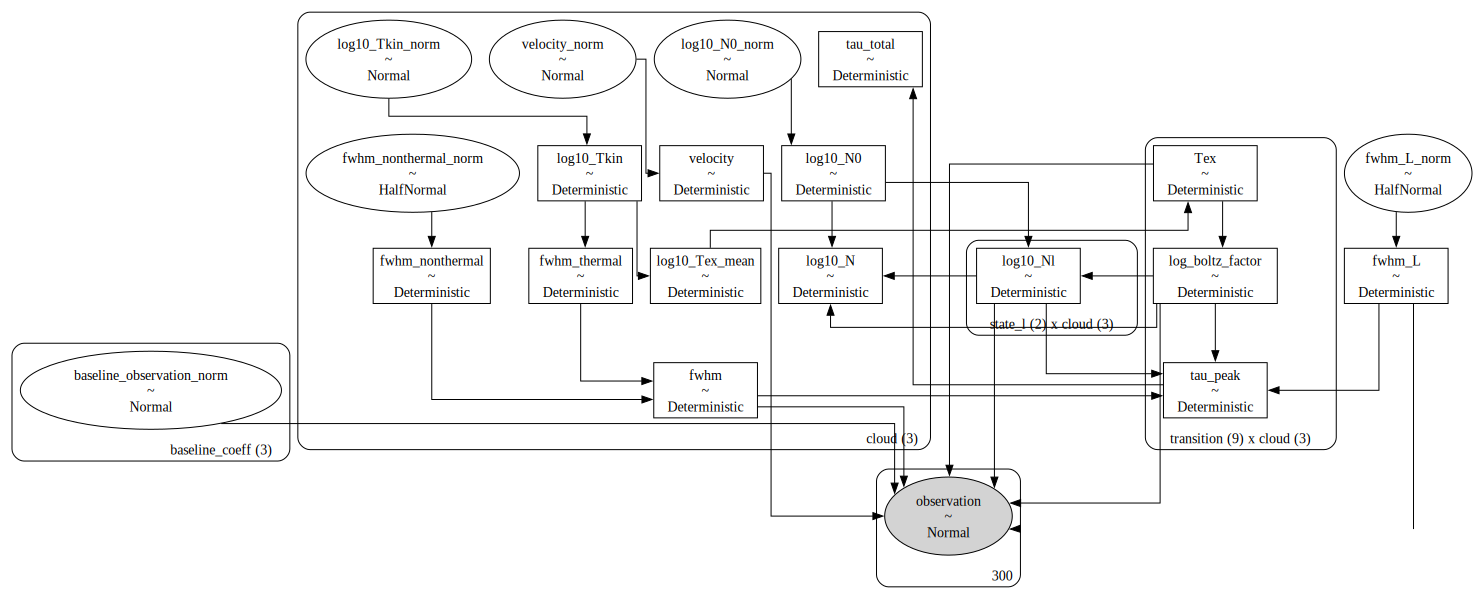

In [52]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [53]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
            log10_N0_norm ~ Normal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
     fwhm_nonthermal_norm ~ HalfNormal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
                 log10_N0 ~ Deterministic(f(log10_N0_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
           log10_Tex_mean ~ Deterministic(f(log10_Tkin_norm))
                      Tex ~ Deterministic(f(log10_Tkin_norm))
         log_boltz_factor ~ Deterministic(f(log10_Tkin_norm))
                 log10_Nl ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                  log10_N ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
          fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                     fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
  

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, observation, velocity_norm]


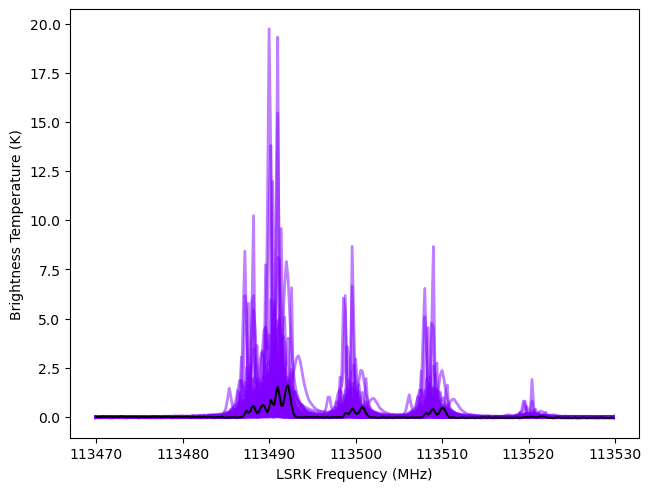

In [54]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [64]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.1, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.03, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 17500
Interrupted at 17,499 [17%]: Average Loss = 529.15


Output()

Runtime: 0.78 minutes


In [62]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0[0]                   12.339  0.001  12.337   12.342      0.000   
log10_N0[1]                   11.793  0.004  11.786   11.800      0.000   
log10_N0[2]                   12.167  0.002  12.164   12.171      0.000   
log10_Tkin[0]                  1.978  0.022   1.941    2.018      0.001   
log10_Tkin[1]                  1.972  0.050   1.874    2.063      0.002   
log10_Tkin[2]                  2.086  0.032   2.023    2.139      0.001   
log10_Tex_mean[0]              1.978  0.022   1.941    2.018      0.001   
log10_Tex_mean[1]              1.972  0.050   1.874    2.063      0.002   
log10_Tex_mean[2]              2.086  0.032   2.023    2.139      0.001   
log10_N[0]                    13.098  0.002  13.095   13.102      0.000   
log10_N[1]                    12.553  0.004  12.544   12.560      0.000   
log10_N[2]                    12.931  0.002  12.927   12.935      0.000   
velocity[0]                   -3.028  0.003  -3.034   -3.023      0.000   
velocity[1]                    1.995  0.006   1.985    2.006      0.000   
velocity[2]                    0.056  0.005   0.045    0.065      0.000   
fwhm_thermal[0]                0.409  0.010   0.392    0.429      0.000   
fwhm_thermal[1]                0.407  0.023   0.363    0.451      0.001   
fwhm_thermal[2]                0.463  0.017   0.431    0.492      0.001   
fwhm_nonthermal[0]             1.967  0.009   1.952    1.987      0.000   
fwhm_nonthermal[1]             0.996  0.016   0.965    1.025      0.000   
fwhm_nonthermal[2]             1.433  0.008   1.418    1.449      0.000   
fwhm[0]                        2.009  0.009   1.993    2.028      0.000   
fwhm[1]                        1.076  0.017   1.046    1.108      0.001   
fwhm[2]                        1.506  0.009   1.487    1.522      0.000   
tau_total[0]                   0.022  0.001   0.020    0.024      0.000   
tau_total[1]                   0.012  0.001   0.009    0.015      0.000   
tau_total[2]                   0.016  0.001   0.014    0.018      0.000   
fwhm_L                         0.015  0.004   0.008    0.022      0.000   
baseline_observation_norm[0]  -1.061  0.065  -1.184   -0.947      0.002   
baseline_observation_norm[1]  -4.846  0.219  -5.275   -4.459      0.007   
baseline_observation_norm[2]   1.600  0.760   0.131    2.945      0.027   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0[0]                     0.000     953.0     906.0    NaN  
log10_N0[1]                     0.000     742.0     860.0    NaN  
log10_N0[2]                     0.000     737.0     634.0    NaN  
log10_Tkin[0]                   0.001     787.0     834.0    NaN  
log10_Tkin[1]                   0.001     942.0     944.0    NaN  
log10_Tkin[2]                   0.001    1112.0    1025.0    NaN  
log10_Tex_mean[0]               0.001     787.0     834.0    NaN  
log10_Tex_mean[1]               0.001     942.0     944.0    NaN  
log10_Tex_mean[2]               0.001    1112.0    1025.0    NaN  
log10_N[0]                      0.000    1033.0     981.0    NaN  
log10_N[1]                      0.000     761.0     982.0    NaN  
log10_N[2]                      0.000     819.0     881.0    NaN  
velocity[0]                     0.000     999.0     901.0    NaN  
velocity[1]                     0.000    1066.0     979.0    NaN  
velocity[2]                     0.000     989.0     769.0    NaN  
fwhm_thermal[0]                 0.000     787.0     834.0    NaN  
fwhm_thermal[1]                 0.001     942.0     944.0    NaN  
fwhm_thermal[2]                 0.000    1112.0    1025.0    NaN  
fwhm_nonthermal[0]              0.000     783.0     786.0    NaN  
fwhm_nonthermal[1]              0.000    1091.0     942.0    NaN  
fwhm_nonthermal[2]              0.000    1025.0     917.0    NaN  
fwhm[0]                         0.000     786.0     805.0    NaN  
fwhm[1]                         0.000    1057.0     676.0    NaN  
fwhm[2]                

Sampling: [observation]


Output()

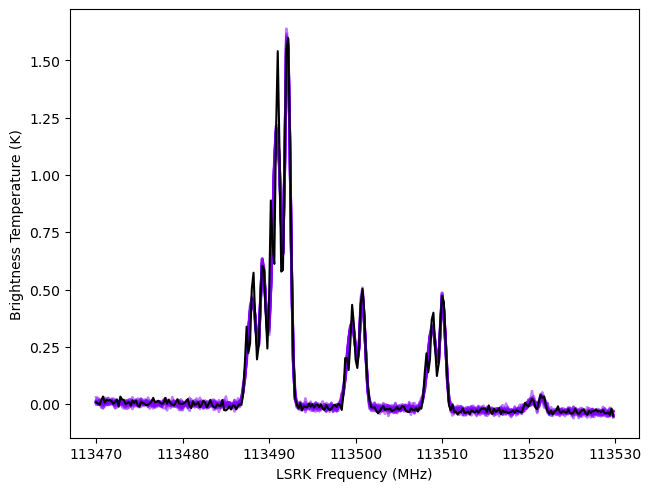

In [50]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.1, "abs_tolerance": 0.1, "learning_rate": 0.03}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 17500
Interrupted at 17,499 [17%]: Average Loss = 529.15
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

In [33]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [34]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0[0]                   12.090  0.028  12.038   12.144      0.000   
log10_N0[1]                   12.387  0.009  12.371   12.405      0.000   
log10_N0[2]                   12.174  0.092  12.005   12.340      0.002   
log10_Tkin[0]                  1.901  0.206   1.532    2.296      0.003   
log10_Tkin[1]                  2.155  0.183   1.819    2.497      0.003   
log10_Tkin[2]                  0.879  0.100   0.730    1.051      0.002   
log10_Tex_mean[0]              1.901  0.206   1.532    2.296      0.003   
log10_Tex_mean[1]              2.155  0.183   1.819    2.497      0.003   
log10_Tex_mean[2]              0.879  0.100   0.730    1.051      0.002   
log10_N[0]                    12.844  0.022  12.802   12.885      0.000   
log10_N[1]                    13.151  0.004  13.144   13.160      0.000   
log10_N[2]                    12.738  0.061  12.624   12.847      0.001   
velocity[0]                   -3.452  0.031  -3.511   -3.395      0.001   
velocity[1]                    0.230  0.008   0.216    0.244      0.000   
velocity[2]                   -2.637  0.026  -2.685   -2.587      0.000   
fwhm_thermal[0]                0.385  0.096   0.232    0.568      0.001   
fwhm_thermal[1]                0.513  0.113   0.327    0.723      0.002   
fwhm_thermal[2]                0.116  0.016   0.097    0.141      0.000   
fwhm_nonthermal[0]             1.556  0.038   1.482    1.624      0.001   
fwhm_nonthermal[1]             3.251  0.029   3.200    3.307      0.000   
fwhm_nonthermal[2]             1.038  0.040   0.964    1.112      0.001   
fwhm[0]                        1.606  0.026   1.557    1.656      0.000   
fwhm[1]                        3.293  0.022   3.250    3.332      0.000   
fwhm[2]                        1.044  0.040   0.970    1.119      0.001   
tau_total[0]                   0.021  0.010   0.005    0.040      0.000   
tau_total[1]                   0.011  0.005   0.003    0.020      0.000   
tau_total[2]                   0.283  0.091   0.118    0.458      0.001   
fwhm_L                         0.005  0.005   0.000    0.013      0.000   
baseline_observation_norm[0]  -1.021  0.074  -1.159   -0.883      0.001   
baseline_observation_norm[1]  -4.829  0.197  -5.191   -4.456      0.002   
baseline_observation_norm[2]   1.592  0.883  -0.113    3.233      0.010   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0[0]                     0.000    3327.0    3940.0    1.0  
log10_N0[1]                     0.000    4158.0    4544.0    1.0  
log10_N0[2]                     0.001    4071.0    2546.0    1.0  
log10_Tkin[0]                   0.002    5016.0    4320.0    1.0  
log10_Tkin[1]                   0.002    4300.0    4222.0    1.0  
log10_Tkin[2]                   0.002    3847.0    2395.0    1.0  
log10_Tex_mean[0]               0.002    5016.0    4320.0    1.0  
log10_Tex_mean[1]               0.002    4300.0    4222.0    1.0  
log10_Tex_mean[2]               0.002    3847.0    2395.0    1.0  
log10_N[0]                      0.000    3171.0    3963.0    1.0  
log10_N[1]                      0.000    4405.0    5024.0    1.0  
log10_N[2]                      0.001    3964.0    2932.0    1.0  
velocity[0]                     0.000    3601.0    4172.0    1.0  
velocity[1]                     0.000   10051.0    5649.0    1.0  
velocity[2]                     0.000    3727.0    4490.0    1.0  
fwhm_thermal[0]                 0.001    5016.0    4320.0    1.0  
fwhm_thermal[1]                 0.001    4300.0    4222.0    1.0  
fwhm_thermal[2]                 0.000    3847.0    2395.0    1.0  
fwhm_nonthermal[0]              0.000    5405.0    3959.0    1.0  
fwhm_nonthermal[1]              0.000    5101.0    4371.0    1.0  
fwhm_nonthermal[2]              0.000    3770.0    4316.0    1.0  
fwhm[0]                         0.000   10429.0    6246.0    1.0  
fwhm[1]                         0.000    9717.0    6741.0    1.0  
fwhm[2]                

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

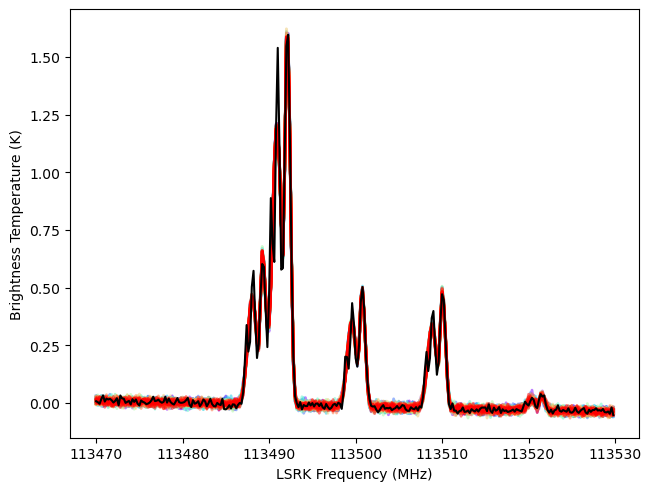

In [35]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

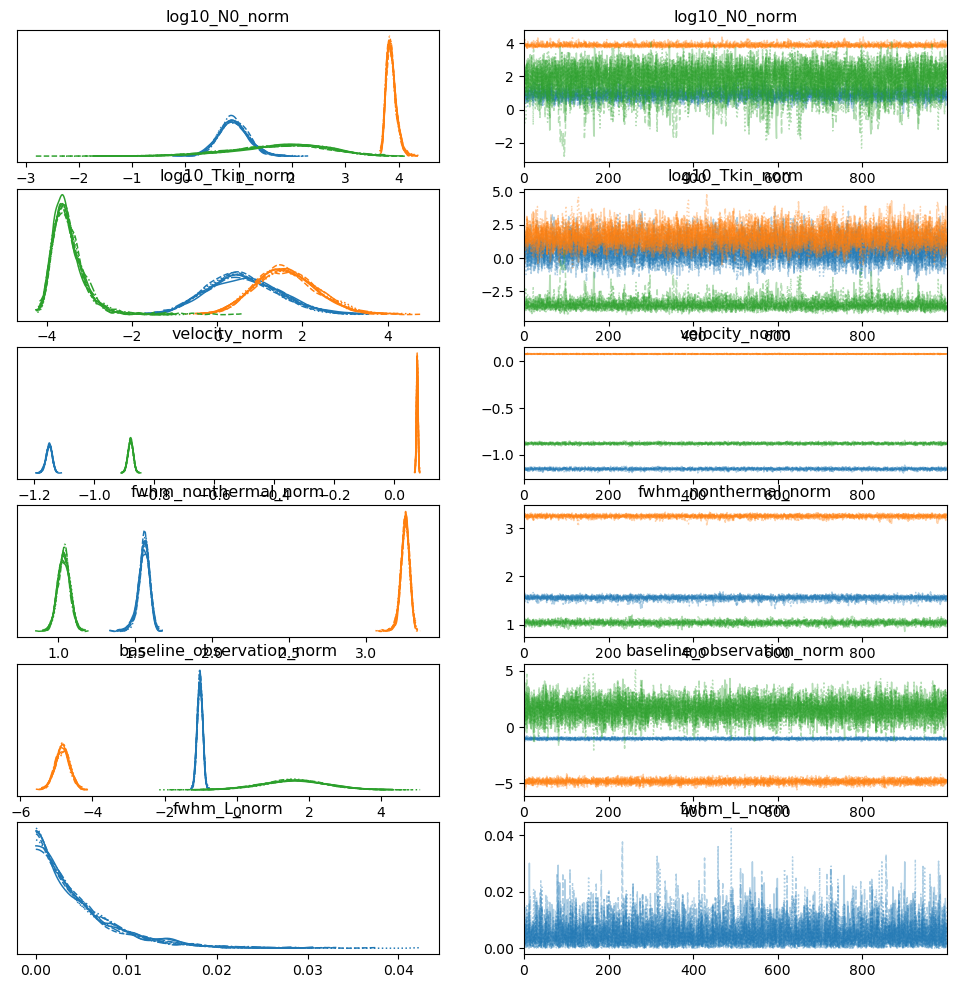

In [36]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

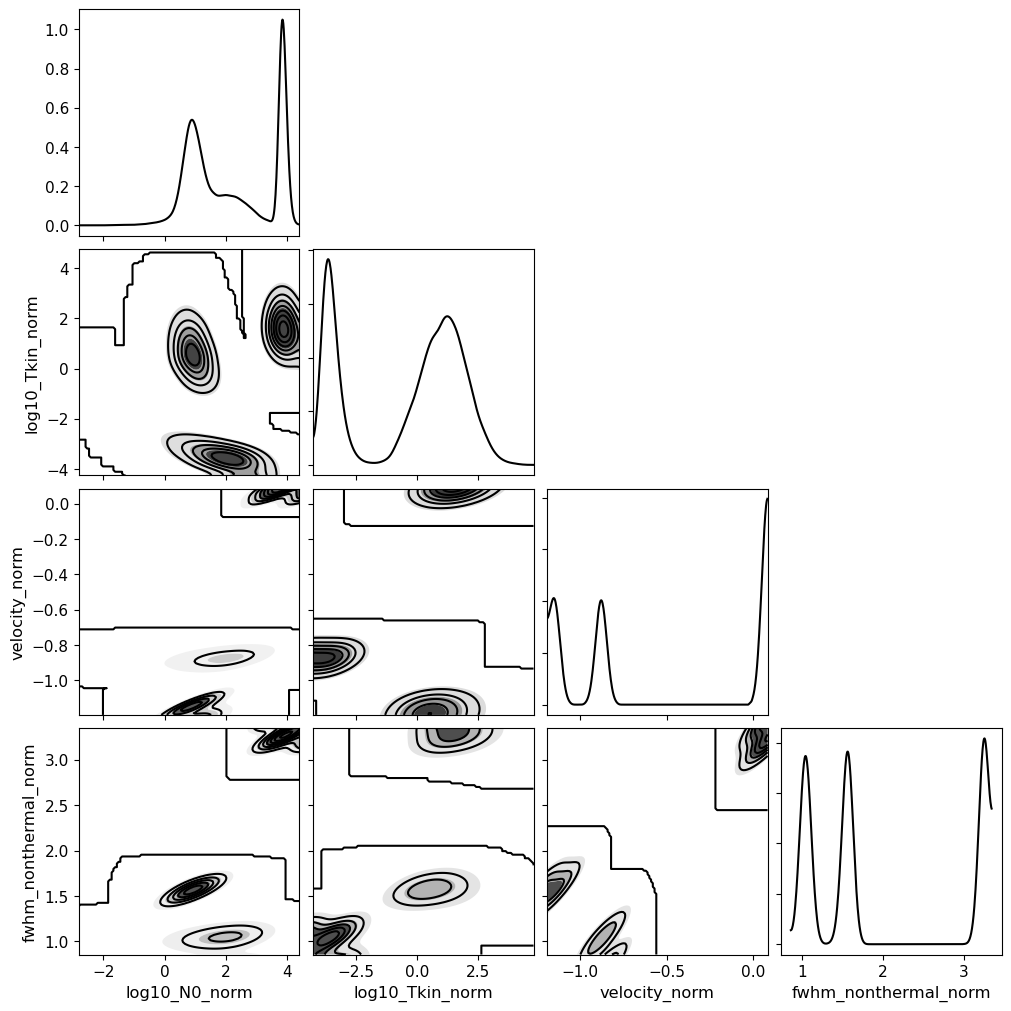

In [37]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

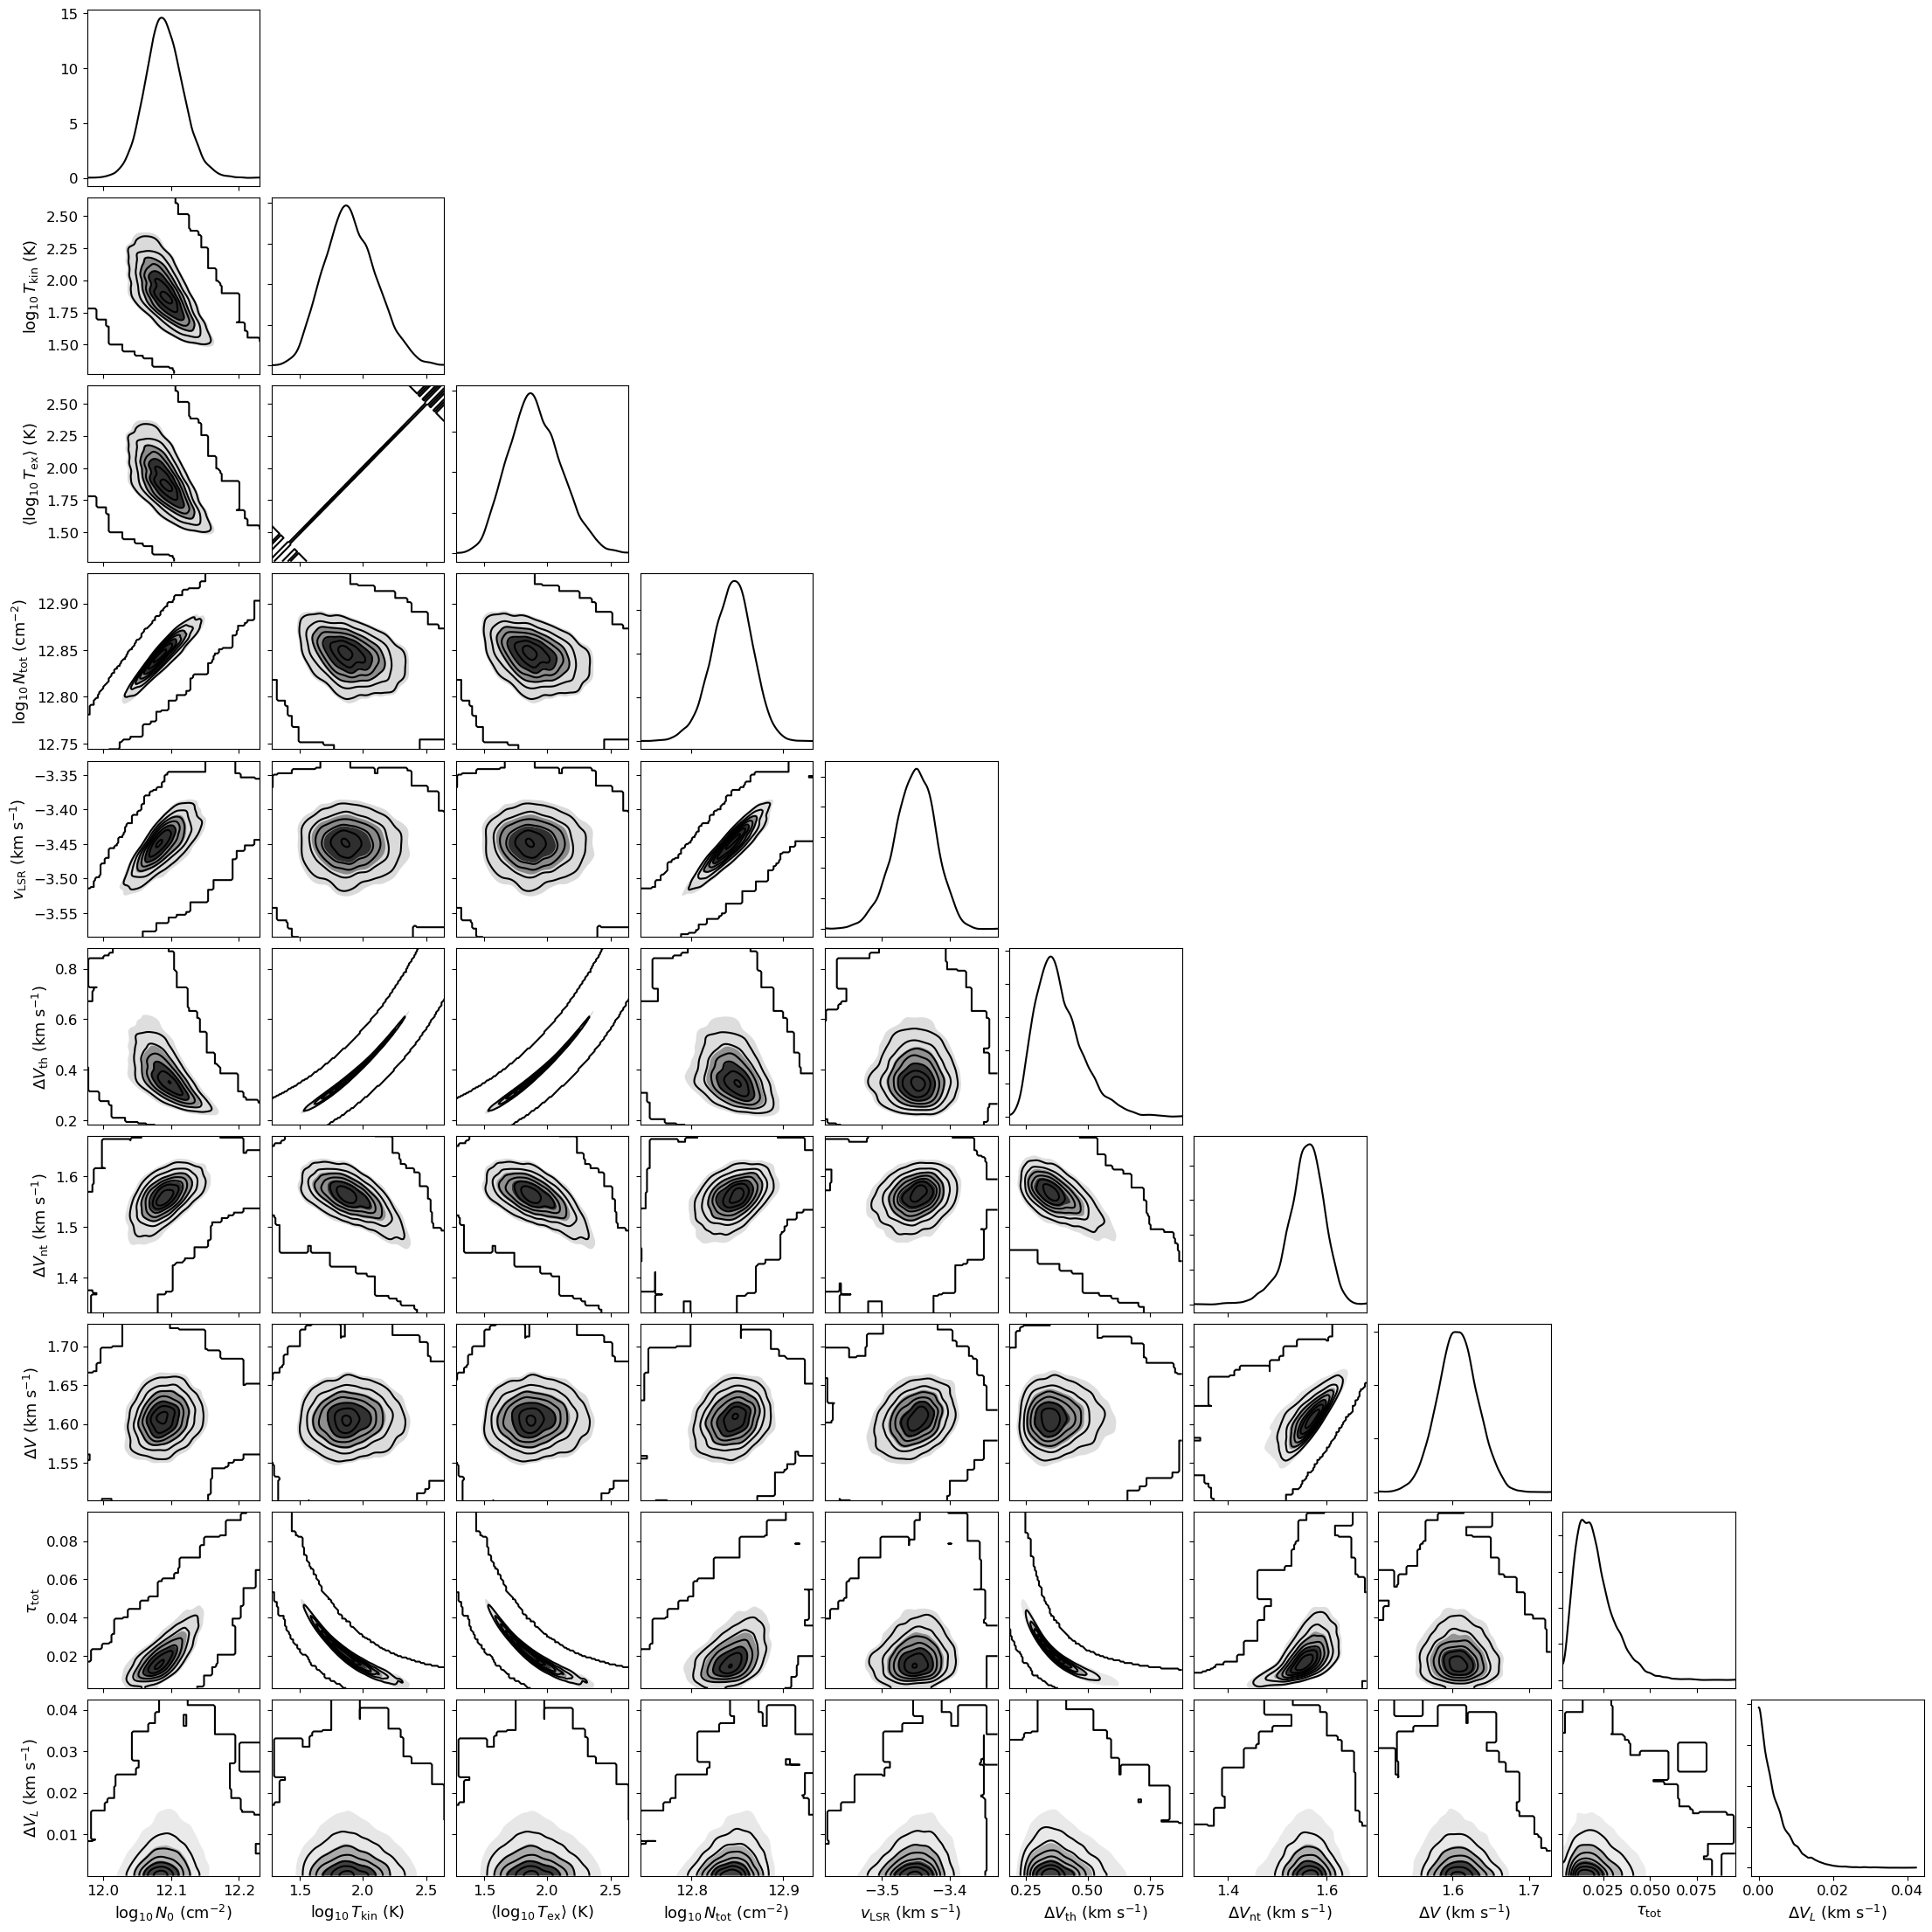

In [38]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_0.png")

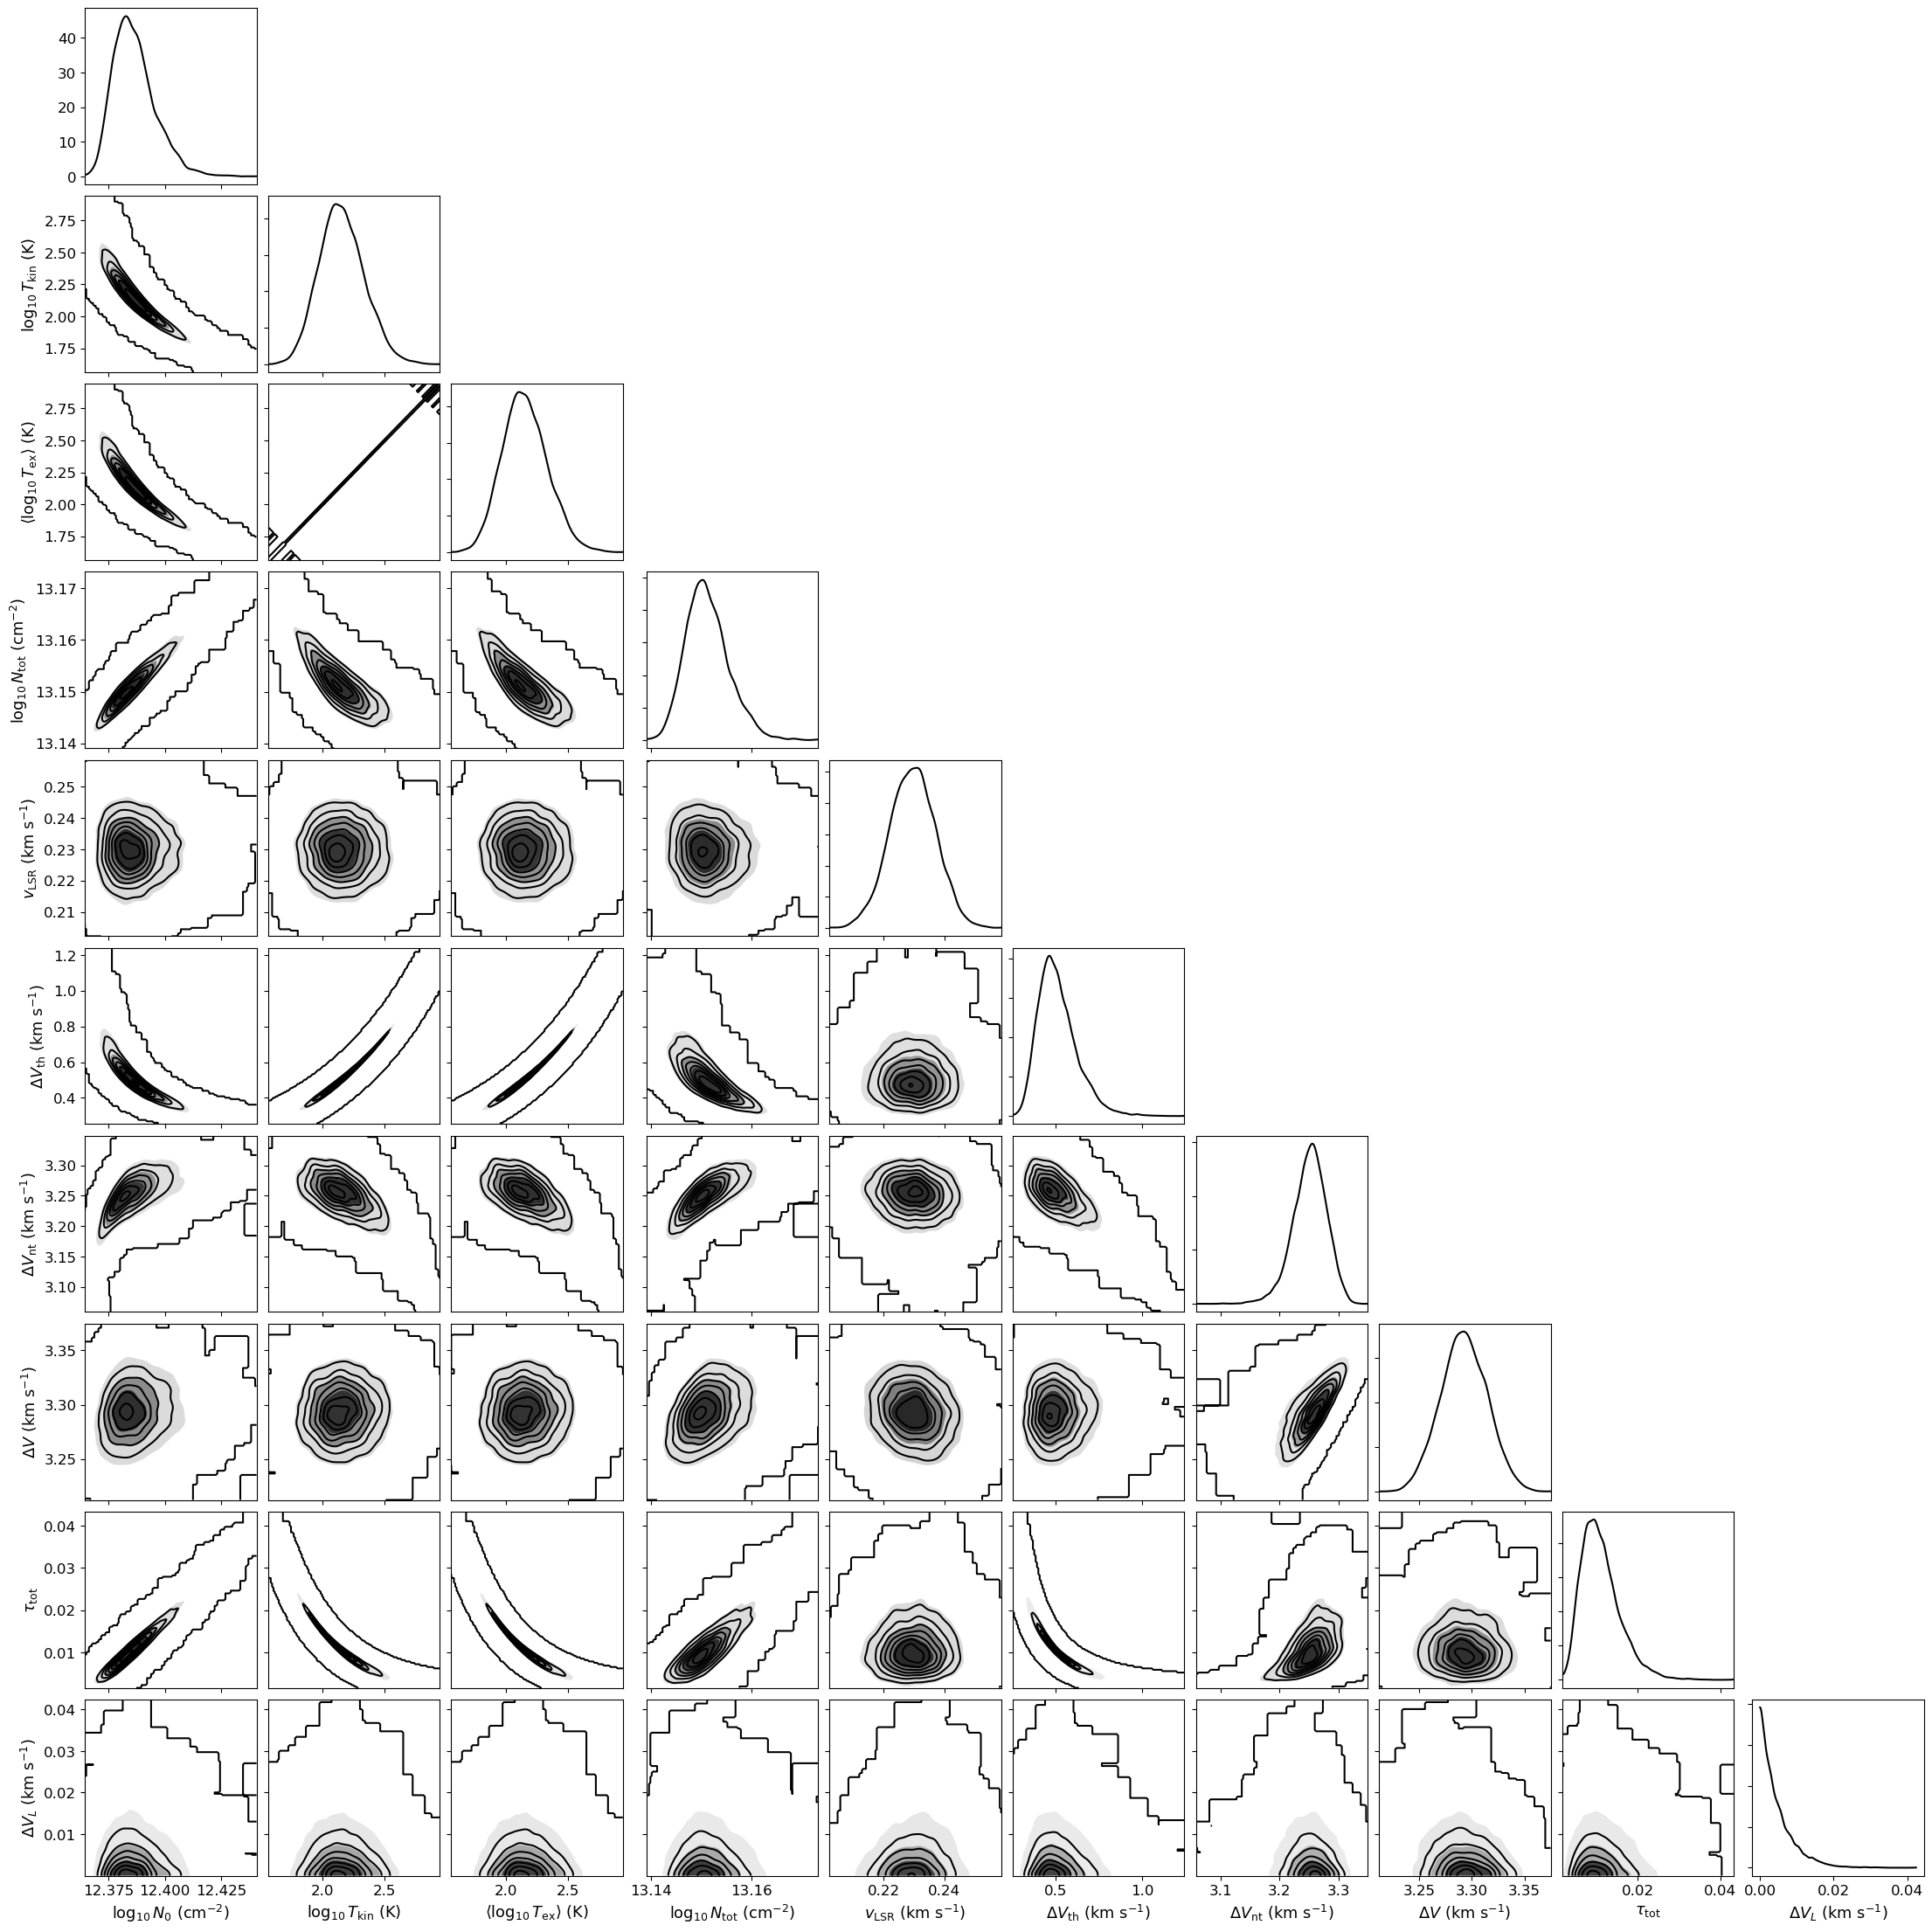

In [39]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

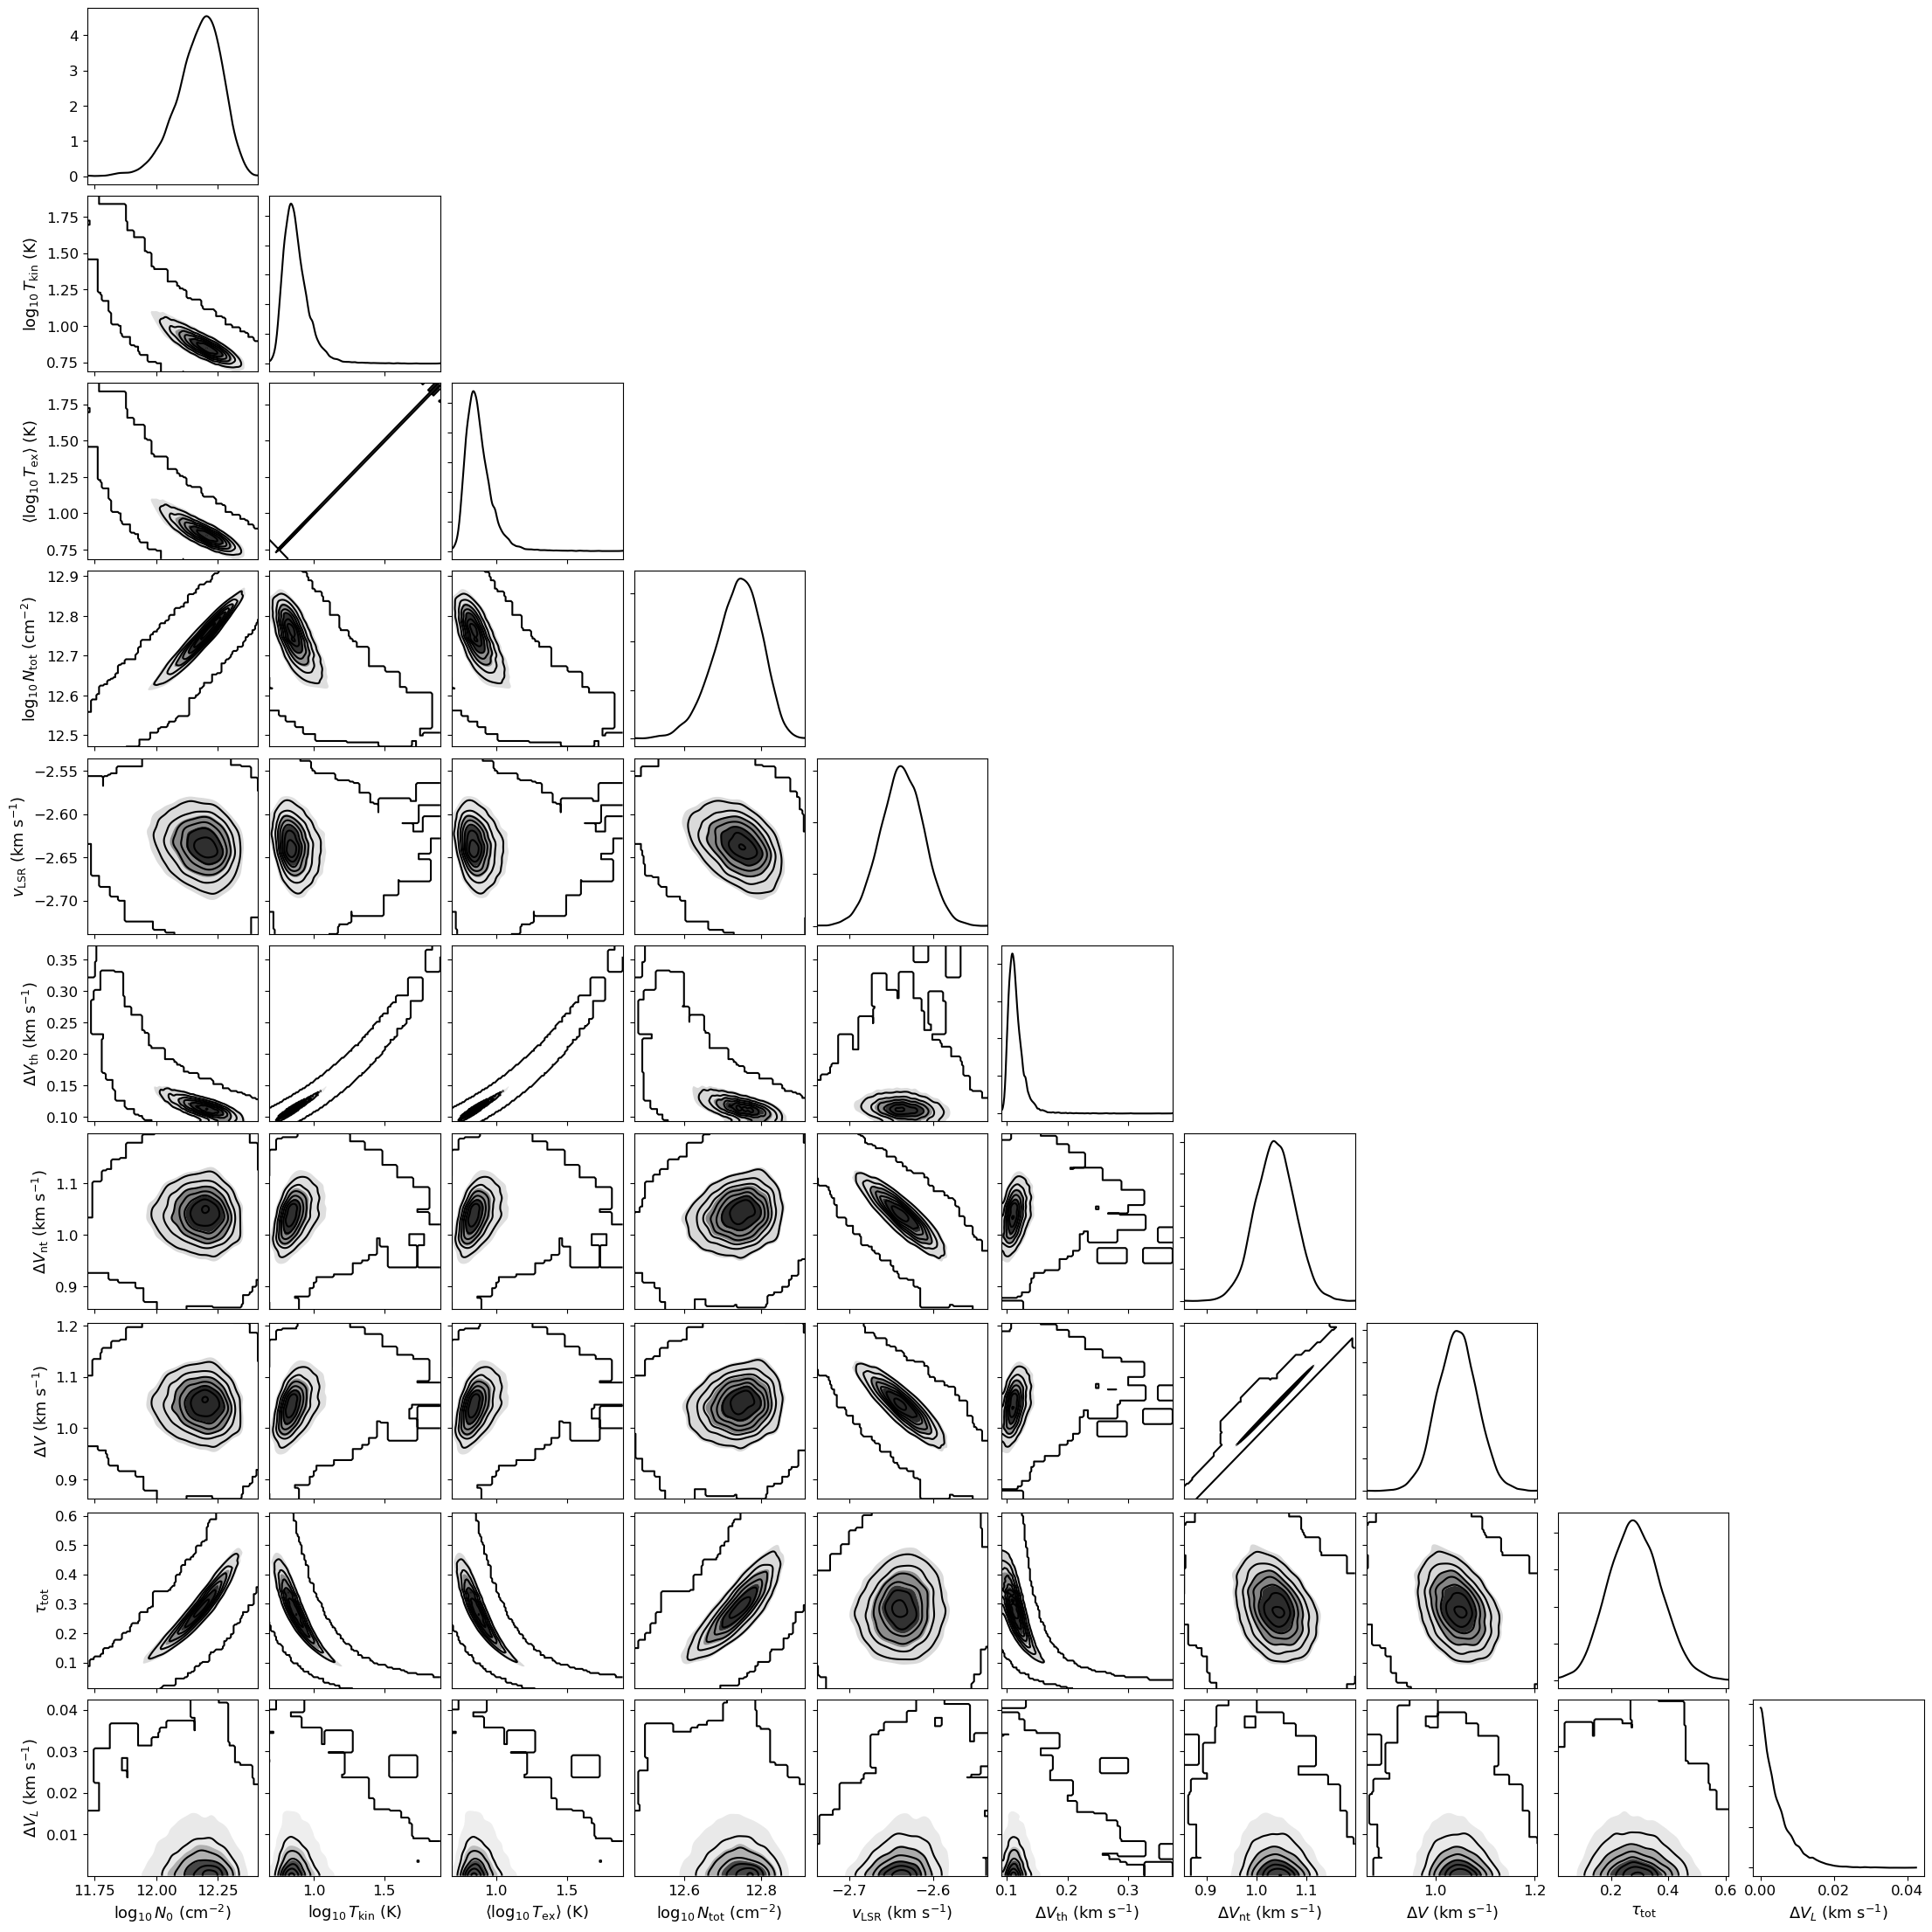

In [40]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_2.png")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [41]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 5061.103202220413


mean      sd  hdi_16%  hdi_84%
log10_N0[0]                        12.090   0.028   12.061   12.116
log10_N0[1]                        12.387   0.009   12.376   12.393
log10_N0[2]                        12.174   0.092   12.114   12.287
log10_Tkin[0]                       1.901   0.206    1.666    2.080
log10_Tkin[1]                       2.155   0.183    1.970    2.329
log10_Tkin[2]                       0.879   0.100    0.774    0.926
log10_Tex_mean[0]                   1.901   0.206    1.666    2.080
log10_Tex_mean[1]                   2.155   0.183    1.970    2.329
log10_Tex_mean[2]                   0.879   0.100    0.774    0.926
Tex[113123.3687, 0]                89.577  47.433   34.044  101.728
Tex[113123.3687, 1]               156.658  74.027   77.124  184.670
Tex[113123.3687, 2]                 7.810   2.699    5.733    8.184
Tex[113144.19, 0]                  89.577  47.433   34.044  101.728
Tex[113144.19, 1]                 156.658  74.027   77.124  184.670
Tex[113144.19, 2]                   7.810   2.699    5.733    8.184
Tex[113170.535, 0]                 89.577  47.433   34.044  101.728
Tex[113170.535, 1]                156.658  74.027   77.124  184.670
Tex[113170.535, 2]                  7.810   2.699    5.733    8.184
Tex[113191.325, 0]                 89.577  47.433   34.044  101.728
Tex[113191.325, 1]                156.658  74.027   77.124  184.670
Tex[113191.325, 2]                  7.810   2.699    5.733    8.184
Tex[113488.142, 0]                 89.577  47.433   34.044  101.728
Tex[113488.142, 1]                156.658  74.027   77.124  184.670
Tex[113488.142, 2]                  7.810   2.699    5.733    8.184
Tex[113490.985, 0]                 89.577  47.433   34.044  101.728
Tex[113490.985, 1]                156.658  74.027   77.124  184.670
Tex[113490.985, 2]                  7.810   2.699    5.733    8.184
Tex[113499.643, 0]                 89.577  47.433   34.044  101.728
Tex[113499.643, 1]                156.658  74.027   77.124  184.670
Tex[113499.643, 2]                  7.810   2.699    5.733    8.184
Tex[113508.934, 0]                 89.577  47.433   34.044  101.728
Tex[113508.934, 1]                156.658  74.027   77.124  184.670
Tex[113508.934, 2]                  7.810   2.699    5.733    8.184
Tex[113520.4215, 0]                89.577  47.433   34.044  101.728
Tex[113520.4215, 1]               156.658  74.027   77.124  184.670
Tex[113520.4215, 2]                 7.810   2.699    5.733    8.184
log_boltz_factor[113123.3687, 0]   -0.076   0.035   -0.095   -0.033
log_boltz_factor[113123.3687, 1]   -0.041   0.017   -0.052   -0.021
log_boltz_factor[113123.3687, 2]   -0.735   0.143   -0.896   -0.628
log_boltz_factor[113144.19, 0]     -0.076   0.035   -0.095   -0.033
log_boltz_factor[113144.19, 1]     -0.041   0.017   -0.052   -0.021
log_boltz_factor[113144.19, 2]     -0.735   0.143   -0.896   -0.628
log_boltz_factor[113170.535, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113170.535, 1]    -0.041   0.017   -0.052   -0.021
log_boltz_factor[113170.535, 2]    -0.735   0.143   -0.896   -0.628
log_boltz_factor[113191.325, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113191.325, 1]    -0.041   0.017   -0.052   -0.021
log_boltz_factor[113191.325, 2]    -0.735   0.143   -0.896   -0.628
log_boltz_factor[113488.142, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113488.142, 1]    -0.042   0.017   -0.052   -0.021
log_boltz_factor[113488.142, 2]    -0.737   0.143   -0.899   -0.630
log_boltz_factor[113490.985, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113490.985, 1]    -0.042   0.017   -0.052   -0.021
log_boltz_factor[113490.985, 2]    -0.737   0.143   -0.899   -0.630
log_boltz_factor[113499.643, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113499.643, 1]    -0.042   0.017   -0.052   -0.021
log_boltz_factor[113499.643, 2]    -0.737   0.143   -0.899   -0.630
log_boltz_factor[113508.934, 0]    -0.076   0.035   -0.095   -0.033
log_boltz_factor[113508.9

In [42]:
print(sim_params)
print(derived_params)

{'log10_N0': [12.5, 12.2, 11.8], 'log10_Tkin': [1.2, 1.8, 1.9], 'fwhm_nonthermal': [2.0, 1.5, 1.0], 'velocity': [-3.0, 0.0, 2.0], 'fwhm_L': 0.0, 'baseline_observation_norm': [-2.0, -5.0, 8.0]}
{'log10_N': array([13.17137344, 12.95036441, 12.55602863]), 'tau_total': array([0.1670993 , 0.03110271, 0.0142802 ])}
